In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os

pandas.options.display.float_format = '{:,.3f}'.format

In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_multiple_grad_cam, get_expert_results

Using TensorFlow backend.


/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,

In [4]:
from data import describe, all_features, data, print_describe, load_single
from run import characterize_data
from config import config

# Parameters

In [5]:
DIRECTORY = os.path.join(os.environ["DATA_DIR"], "liver-ultrasound")
MODEL_UUID = "04cfb42d-3e0b-4516-aa85-56f19cb4d6b9"
MODEL_TYPE = "v2"
SELECTIONS = "None"
PARAMETERS_ID = "parameters"

In [6]:
# Parameters
DIRECTORY = "/media/user1/my4TB/intrepidlemon/liver-ultrasound/fixed"
MODEL_UUID = "cbd87d38-62c5-4196-9c5f-d967eac37085"
MODEL_TYPE = "v2"
SELECTIONS = "[]"
PARAMETERS_ID = "fixed-complete"


In [7]:
SELECTIONS = eval(SELECTIONS)
FEATURES = config.FEATURES
RAW = "{}/raw".format(DIRECTORY)
TRAIN = "{}/train".format(DIRECTORY)
VALIDATION = "{}/validation".format(DIRECTORY)
MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, MODEL_UUID, MODEL_TYPE)

## Lesion descriptions

In [8]:
train, validation, test = data(shuffle_train=False, validation_dir=VALIDATION, train_dir=TRAIN)

Found 660 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


Found 82 images belonging to 2 classes.


In [9]:
print("training data breakdown: ", characterize_data(train))
print("validation data breakdown: ", characterize_data(validation))
print("validation data breakdown: ", characterize_data(test))

training data breakdown:  {'benign': 280, 'malignant': 380}
validation data breakdown:  {'benign': 64, 'malignant': 108}
validation data breakdown:  {'benign': 41, 'malignant': 41}


In [10]:
len(train)

42

In [11]:
print(validation.n)

172


In [12]:
model = load(MODEL)

In [13]:
results = get_results(model, test)

In [14]:
results

array([[9.3834684e-10],
       [1.7156064e-05],
       [1.6968173e-03],
       [2.6547268e-04],
       [9.7264476e-02],
       [4.7149407e-04],
       [8.1823973e-06],
       [5.3904392e-03],
       [7.3676711e-01],
       [7.0246321e-01],
       [1.5032325e-02],
       [1.7376892e-07],
       [1.3913496e-01],
       [2.8017223e-05],
       [3.4098798e-01],
       [7.2636402e-01],
       [2.6732874e-01],
       [3.5132751e-02],
       [7.3662722e-01],
       [1.5282094e-04],
       [7.5663376e-01],
       [7.1742690e-01],
       [3.3838322e-04],
       [1.3089909e-02],
       [7.0280927e-01],
       [6.7080837e-04],
       [2.1276593e-02],
       [2.2926901e-03],
       [9.9793971e-02],
       [3.9707762e-03],
       [9.6160017e-02],
       [1.5780570e-02],
       [2.2008987e-08],
       [7.0252264e-01],
       [1.2706496e-01],
       [4.3170914e-02],
       [8.0120692e-09],
       [5.9442323e-01],
       [6.6994891e-02],
       [1.4127192e-01],
       [3.3873063e-02],
       [7.034194

In [15]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(test)

## Accuracy and loss

In [16]:
loss, accuracy = calculate_accuracy_loss(model, test)
print("Accuracy:", accuracy)
print("Loss:", loss)

Accuracy: 0.8170731707317073
Loss: 0.44736687293866784


## Confusion matrix

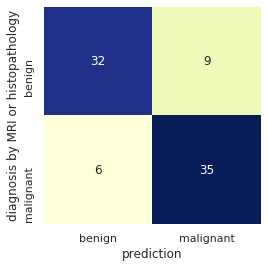

In [17]:
fig = plot_confusion_matrix(test, results)
fig.savefig("figures/{}-confusion-matrix.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [18]:
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=test.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR
benign,0.817,32,35,6,9,0.780,0.854,0.842,0.795,0.146,0.220,0.158
malignant,0.817,35,32,9,6,0.854,0.780,0.795,0.842,0.220,0.146,0.205


## ROC Curve standalone

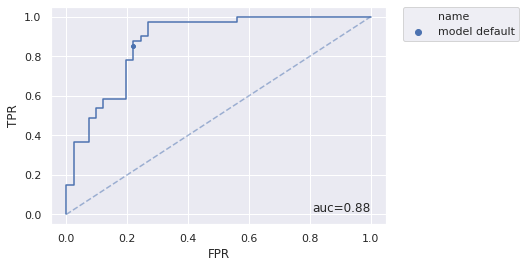

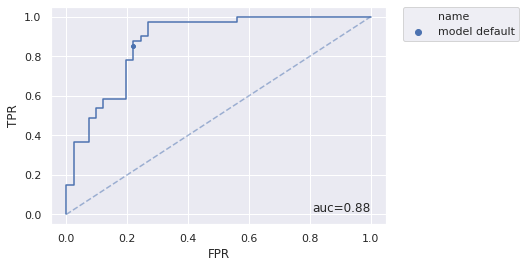

In [19]:
plot_roc_curve(labels, results)

In [20]:
print("ROC AUC:", roc_auc_score(labels, probabilities))

ROC AUC: 0.8762641284949435


## Precision Recall

In [21]:
print("Average precision:", average_precision_score(labels, probabilities))
print("Precision:", precision_score(labels, predictions), "Recall:", recall_score(labels, predictions))

Average precision: 0.853875931832906
Precision: 0.7954545454545454 Recall: 0.8536585365853658


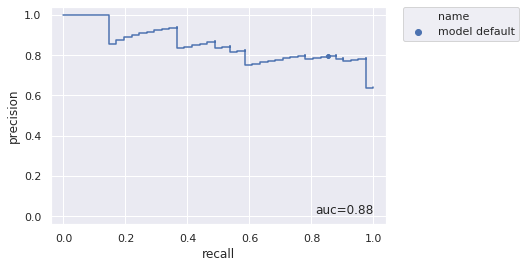

In [22]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-precision-recall.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [23]:
print("PR AUC:", calculate_pr_auc(labels, results))

PR AUC: 0.8510039412100212


## F1 Score

In [24]:
print("F1 score:", f1_score(labels, predictions))

F1 score: 0.8235294117647058


## TSNE

In [25]:
diagnosis, malignancy, evidence = all_features(features=FEATURES)

In [26]:
tsne_dataset = train

In [27]:
train_results = get_results(model, train)
train_predictions = ["malignant" if t else "benign" for t in transform_binary_predictions(train_results)]

In [28]:
tsne_labels = [[malignancy.get(accession_from_filename(f), "unknown") for f in tsne_dataset.filenames], train_predictions]

In [29]:
tsne_labels

[['benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'benign',
  'b

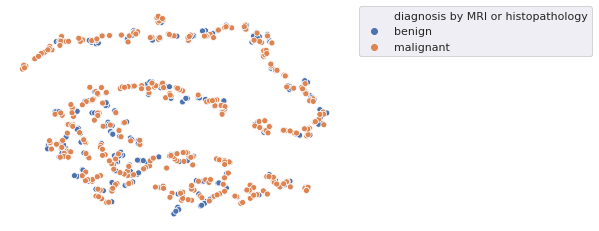

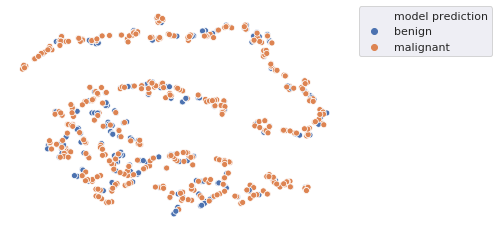

In [30]:
fig = plot_tsne(model, "dense_5", tsne_dataset, tsne_labels, perplexity=5, fieldnames=["diagnosis by MRI or histopathology", "model prediction"])
fig[0].savefig("figures/label-{}-tsne.svg".format(PARAMETERS_ID), bbox_inches = "tight")
fig[1].savefig("figures/model-{}-tsne.svg".format(PARAMETERS_ID), bbox_inches = "tight")

## Experts

In [31]:
get_expert_results("evaluations/radiology-3344.json", test.filenames)

error with benign/fixed-27026916.jpeg: '27026916.jpeg'
error with benign/fixed-27808351.jpeg: '27808351.jpeg'
error with benign/fixed-27954713-1.jpeg: '27954713-1.jpeg'
error with benign/fixed-27954713-2.jpeg: '27954713-2.jpeg'
error with benign/fixed-6041779.jpeg: '6041779.jpeg'
error with benign/fixed-7363540-1.jpeg: '7363540-1.jpeg'
error with benign/fixed-8217457-1.jpeg: '8217457-1.jpeg'
error with malignant/fixed-5829440.jpeg: '5829440.jpeg'
error with malignant/fixed-7221037.jpeg: '7221037.jpeg'
error with malignant/fixed-7336509.jpeg: '7336509.jpeg'
error with malignant/fixed-7343132.jpeg: '7343132.jpeg'
error with malignant/fixed-7419872.jpeg: '7419872.jpeg'
error with malignant/fixed-7486948-1.jpeg: '7486948-1.jpeg'
error with malignant/fixed-7486948-2.jpeg: '7486948-2.jpeg'
error with malignant/fixed-7486948-3.jpeg: '7486948-3.jpeg'
error with malignant/fixed-7486948-4.jpeg: '7486948-4.jpeg'
error with malignant/fixed-7637848-1.jpeg: '7637848-1.jpeg'
error with malignant/fixe

['benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 None,
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 None,
 'benign',
 'malignant',
 None,
 None,
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 None,
 None,
 None,
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

error with benign/fixed-26805873.jpeg: '26805873.jpeg'
error with benign/fixed-27026916.jpeg: '27026916.jpeg'
error with benign/fixed-27244981.jpeg: '27244981.jpeg'
error with benign/fixed-4782399.jpeg: '4782399.jpeg'
error with malignant/fixed-26699890-1.jpeg: '26699890-1.jpeg'
error with malignant/fixed-26699890-2.jpeg: '26699890-2.jpeg'
error with malignant/fixed-26699890-3.jpeg: '26699890-3.jpeg'
error with malignant/fixed-26699890.jpeg: '26699890.jpeg'
error with malignant/fixed-26943899-1.jpeg: '26943899-1.jpeg'
error with malignant/fixed-26943899-2.jpeg: '26943899-2.jpeg'
error with malignant/fixed-26998526-1.jpeg: '26998526-1.jpeg'
error with malignant/fixed-26998526-2.jpeg: '26998526-2.jpeg'
error with malignant/fixed-26998526-3.jpeg: '26998526-3.jpeg'
error with malignant/fixed-26998526.jpeg: '26998526.jpeg'
error with malignant/fixed-27251611-1.jpeg: '27251611-1.jpeg'
error with malignant/fixed-27251611-2.jpeg: '27251611-2.jpeg'
error with malignant/fixed-27251611-3.jpeg: '2

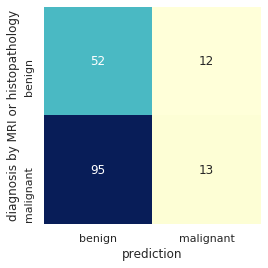

In [32]:
expert_1, fig = plot_expert_confusion("evaluations/radiology-9809.json", validation)
fig.savefig("figures/{}-confusion-matrix-expert-1.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [33]:
pandas.DataFrame(expert_1, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR
benign,0.378,52,13,95,12,0.812,0.120,0.354,0.520,0.880,0.188,0.646
malignant,0.378,13,52,12,95,0.120,0.812,0.520,0.354,0.188,0.880,0.480


## ROC with experts

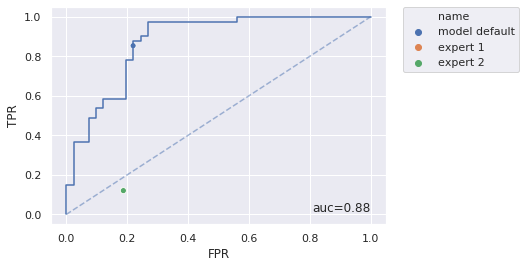

In [34]:
fig = plot_roc_curve(labels, results, experts=[{ **expert_1, "name":"expert 1" }, { **expert_1, "name":"expert 2" }])
fig.savefig("figures/{}-roc-curve.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [35]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')